### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🧠 Notebook At a Glance</p>

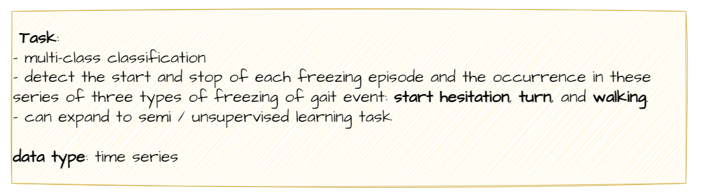

## Data preparation overview

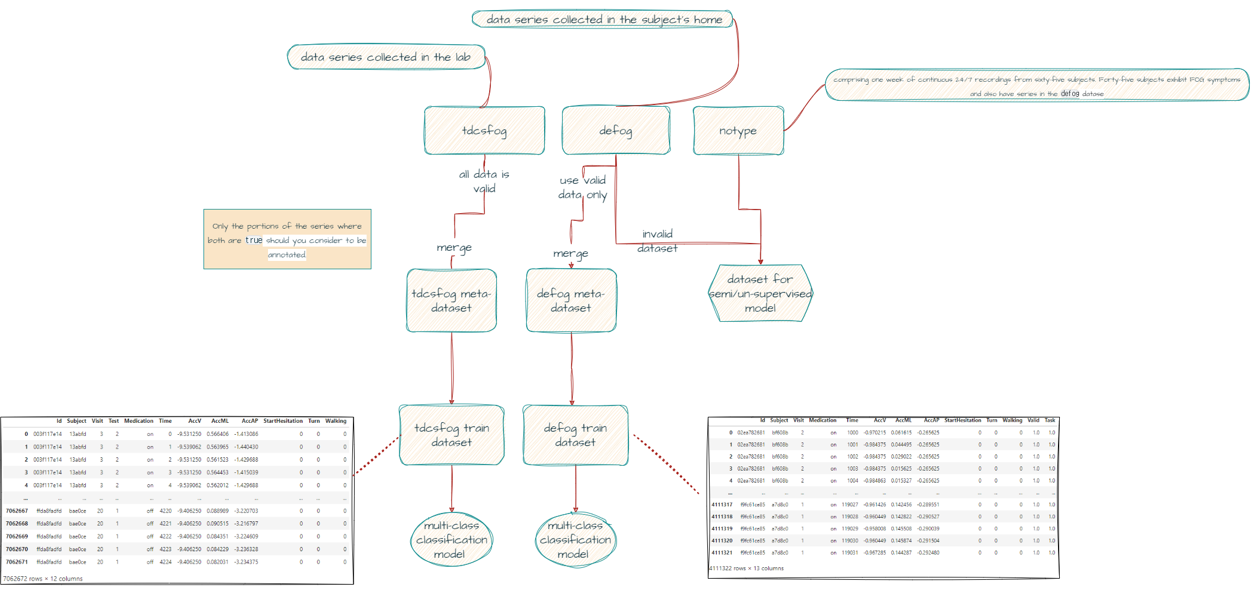

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* tdcsfog dataset are collected from the lab. Therefore, data quality is good comparing with defog dataset.
* defog dataset are collected from subjects' home, therefore there are two additioanl columns (valid & test) to check the quality of data.
* On evaluation precess, it only uses validly annotated data. Therefore, it's reasonable to remove invalid data from defog dataset.
* However, as the document mentioned, we can use it for developing semi or unsupervised model (with notype dataset)
* As the size of dataset is quite huge, we should convert data type to reduce memory usage.
* Need to build two different model. one for tdcsfog and one for defog. Because, via EDA, you could find that both datasets' distribution is different.
* This is just an initial plan for modeling. It could be changed as we dig more into the dataset.

In [1]:
# import library
import os
import random
import cv2
import pandas as pd
import numpy as np

In [2]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [3]:
#reference: https://www.kaggle.com/code/ghrangel/read-data-and-merge

DATA_ROOT_DEFOG = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/'
defog = pd.DataFrame()
for root, dirs, files in os.walk(DATA_ROOT_DEFOG):
    for name in files:       
        f = os.path.join(root, name)
        df_list= pd.read_csv(f)
        words = name.split('.')[0]
        df_list['file']= name.split('.')[0]
        defog = pd.concat([defog, df_list], axis=0)

defog
       

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,file
0,0,-1.002697,0.022371,0.068304,0,0,0,False,False,be9d33541d
1,1,-1.002641,0.019173,0.066162,0,0,0,False,False,be9d33541d
2,2,-0.999820,0.019142,0.067536,0,0,0,False,False,be9d33541d
3,3,-0.998023,0.018378,0.068409,0,0,0,False,False,be9d33541d
4,4,-0.998359,0.016726,0.066448,0,0,0,False,False,be9d33541d
...,...,...,...,...,...,...,...,...,...,...
109120,109120,-0.939241,0.031564,-0.394737,0,0,0,False,False,06414383cf
109121,109121,-0.941096,0.031582,-0.392626,0,0,0,False,False,06414383cf
109122,109122,-0.940131,0.029092,-0.394385,0,0,0,False,False,06414383cf
109123,109123,-0.939872,0.028058,-0.398664,0,0,0,False,False,06414383cf


In [4]:
defog = reduce_memory_usage(defog)

Memory usage of dataframe is 954.53 MB
Memory usage became:  335.3796806335449  MB


In [5]:
defog = defog[(defog['Task']==1)&(defog['Valid']==1)]

> #### 💬 As I mentioned above, We are going to use valid data only.

In [6]:
print('the shape of defog dataset is {}'.format(defog.shape))

the shape of defog dataset is (4090530, 10)


> ###  combining it with metadata.

In [7]:
defog_metadata = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv")
defog_metadata

,Id,Subject,Visit,Medication
0,02ab235146,e1f62e,2,on
1,02ea782681,ae2d35,2,on
2,06414383cf,8c1f5e,2,off
3,092b4c1819,2874c5,1,off
4,0a900ed8a2,0e3d49,2,on
...,...,...,...,...
132,f3a921edee,1a778d,1,off
133,f40e8c6ebe,575c60,1,off
134,f8ddbdd98d,107712,1,on
135,f9efef91fb,5d9cae,2,off


In [8]:
defog_m= defog_metadata.merge(defog, how = 'inner', left_on = 'Id', right_on = 'file')
defog_m.drop(['file','Valid','Task'], axis = 1, inplace = True)
defog_m

,Id,Subject,Visit,Medication,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,02ea782681,ae2d35,2,on,1000,-0.970215,0.061615,-0.265625,0,0,0
1,02ea782681,ae2d35,2,on,1001,-0.984375,0.044495,-0.265625,0,0,0
2,02ea782681,ae2d35,2,on,1002,-0.984375,0.029022,-0.265625,0,0,0
3,02ea782681,ae2d35,2,on,1003,-0.984375,0.015625,-0.265625,0,0,0
4,02ea782681,ae2d35,2,on,1004,-0.984863,0.015327,-0.265625,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4090525,f9fc61ce85,040587,1,on,119027,-0.961426,0.142456,-0.289551,0,0,0
4090526,f9fc61ce85,040587,1,on,119028,-0.960449,0.142822,-0.290527,0,0,0
4090527,f9fc61ce85,040587,1,on,119029,-0.958008,0.145508,-0.290039,0,0,0
4090528,f9fc61ce85,040587,1,on,119030,-0.960449,0.145874,-0.291504,0,0,0


In [9]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [10]:
summary(defog_m)

data shape: (4090530, 11)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
Id,object,0,0.0,91,NaN,NaN,02ea782681,02ea782681,02ea782681
Subject,object,0,0.0,38,NaN,NaN,ae2d35,ae2d35,ae2d35
Visit,int64,0,0.0,2,1.0,2.0,2,2,2
Medication,object,0,0.0,2,NaN,NaN,on,on,on
Time,int32,0,0.0,338197,1000.0,414387.0,1000,1001,1002
AccV,float16,0,0.0,3605,-6.023438,4.457031,-0.970215,-0.984375,-0.984375
AccML,float16,0,0.0,28088,-2.115234,4.523438,0.061615,0.044495,0.029022
AccAP,float16,0,0.0,23944,-5.117188,4.386719,-0.265625,-0.265625,-0.265625
StartHesitation,int8,0,0.0,2,0.0,1.0,0,0,0
Turn,int8,0,0.0,2,0.0,1.0,0,0,0


In [11]:
# garbage collection for memory
import gc
gc.collect()

21

> ### prepare tdcsfog dataset for modeling (data collected from the lab🥼)

In [12]:
DATA_ROOT_TDCSFOG = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/'
tdcsfog = pd.DataFrame()
for root, dirs, files in os.walk(DATA_ROOT_TDCSFOG):
    for name in files:       
        f = os.path.join(root, name)
        df_list= pd.read_csv(f)
        words = name.split('.')[0]
        df_list['file']= name.split('.')[0]
        tdcsfog = pd.concat([tdcsfog, df_list], axis=0)
tdcsfog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,file
0,0,-9.665890,0.042550,0.184744,0,0,0,a171e61840
1,1,-9.672969,0.049217,0.184644,0,0,0,a171e61840
2,2,-9.670260,0.033620,0.193790,0,0,0,a171e61840
3,3,-9.673356,0.035159,0.184369,0,0,0,a171e61840
4,4,-9.671458,0.043913,0.197814,0,0,0,a171e61840
...,...,...,...,...,...,...,...,...
5153,5153,-9.915920,-0.105897,-1.123455,0,0,0,0506d9a39f
5154,5154,-9.693752,-0.066892,-1.114903,0,0,0,0506d9a39f
5155,5155,-9.548118,-0.098315,-1.112123,0,0,0,0506d9a39f
5156,5156,-9.469803,-0.111004,-1.130814,0,0,0,0506d9a39f


In [13]:
tdcsfog = reduce_memory_usage(tdcsfog)

Memory usage of dataframe is 484.96 MB
Memory usage became:  154.95413208007812  MB


In [14]:
tdcsfog_metadata = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv")
tdcsfog_metadata

,Id,Subject,Visit,Test,Medication
0,003f117e14,4dc2f8,3,2,on
1,009ee11563,f62eec,4,2,on
2,011322847a,231c3b,2,2,on
3,01d0fe7266,231c3b,2,1,off
4,024418ba39,fa8764,19,3,on
...,...,...,...,...,...
828,feba449e1a,312788,19,1,on
829,ff4f844fd3,af82b2,2,3,on
830,ff53514514,3b2403,2,3,on
831,ff92d9244d,2d57c2,20,2,on


In [15]:
tdcsfog_m= tdcsfog_metadata.merge(tdcsfog, how = 'inner', left_on = 'Id', right_on = 'file')
tdcsfog_m.drop(['file'], axis = 1, inplace = True)
tdcsfog_m

,Id,Subject,Visit,Test,Medication,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,003f117e14,4dc2f8,3,2,on,0,-9.531250,0.566406,-1.413086,0,0,0
1,003f117e14,4dc2f8,3,2,on,1,-9.539062,0.563965,-1.440430,0,0,0
2,003f117e14,4dc2f8,3,2,on,2,-9.531250,0.561523,-1.429688,0,0,0
3,003f117e14,4dc2f8,3,2,on,3,-9.531250,0.564453,-1.415039,0,0,0
4,003f117e14,4dc2f8,3,2,on,4,-9.539062,0.562012,-1.429688,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7062667,ffda8fadfd,7fcee9,20,1,off,4220,-9.406250,0.088989,-3.220703,0,0,0
7062668,ffda8fadfd,7fcee9,20,1,off,4221,-9.406250,0.090515,-3.216797,0,0,0
7062669,ffda8fadfd,7fcee9,20,1,off,4222,-9.406250,0.084351,-3.224609,0,0,0
7062670,ffda8fadfd,7fcee9,20,1,off,4223,-9.406250,0.084229,-3.236328,0,0,0


In [16]:
summary(tdcsfog_m)

data shape: (7062672, 12)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
Id,object,0,0.0,833,NaN,NaN,003f117e14,003f117e14,003f117e14
Subject,object,0,0.0,62,NaN,NaN,4dc2f8,4dc2f8,4dc2f8
Visit,int64,0,0.0,7,2.0,20.0,3,3,3
Test,int64,0,0.0,3,1.0,3.0,2,2,2
Medication,object,0,0.0,2,NaN,NaN,on,on,on
Time,int32,0,0.0,97077,0.0,97076.0,0,1,2
AccV,float16,0,0.0,4080,-35.53125,20.90625,-9.53125,-9.539062,-9.53125
AccML,float16,0,0.0,30511,-26.171875,27.484375,0.566406,0.563965,0.561523
AccAP,float16,0,0.0,27751,-47.84375,30.34375,-1.413086,-1.44043,-1.429688
StartHesitation,int8,0,0.0,2,0.0,1.0,0,0,0


In [17]:
# garbage collection for memory
import gc
gc.collect()

21

# Feature engineering and modeling

In [18]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [19]:
conditions = [
    (defog_m['StartHesitation'] == 1),
    (defog_m['Turn'] == 1),
    (defog_m['Walking'] == 1)]
choices = ['StartHesitation', 'Turn', 'Walking']
defog_m['event'] = np.select(conditions, choices, default='Normal')

In [20]:
defog_m['event'].value_counts().to_frame().style.background_gradient()

,event
Normal,3404683
Turn,586829
Walking,98518
StartHesitation,500


In [21]:
train_df = defog_m[['AccV','AccML','AccAP','event']]

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_df['target'] = le.fit_transform(train_df['event'])

In [23]:
X = train_df.drop(['event','target'], axis=1)
y = train_df['target']

In [24]:
X

,AccV,AccML,AccAP
0,-0.970215,0.061615,-0.265625
1,-0.984375,0.044495,-0.265625
2,-0.984375,0.029022,-0.265625
3,-0.984375,0.015625,-0.265625
4,-0.984863,0.015327,-0.265625
...,...,...,...
4090525,-0.961426,0.142456,-0.289551
4090526,-0.960449,0.142822,-0.290527
4090527,-0.958008,0.145508,-0.290039
4090528,-0.960449,0.145874,-0.291504


In [25]:
y

0          0
1          0
2          0
3          0
4          0
          ..
4090525    0
4090526    0
4090527    0
4090528    0
4090529    0
Name: target, Length: 4090530, dtype: int64

In [26]:
y.unique()

array([0, 2, 3, 1])

In [27]:
y.value_counts()

0    3404683
2     586829
3      98518
1        500
Name: target, dtype: int64

In [28]:
import lightgbm as lgb


# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)

#Converting the dataset in proper LGB format
d_train=lgb.Dataset(X_train, label=y_train)
#setting up the parameters
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=7
params['num_class']=4 #no.of unique values in the target class not inclusive of the end value
params['verbose']=-1
#training the model
clf=lgb.train(params,d_train,1000)  #training the model on 1,000 epocs
#prediction on the test dataset
y_pred_1=clf.predict(X_test)

> #### 💬 Let's look at what it predicts

In [29]:
y_pred_1[:1]

array([[5.06787292e-01, 1.10215245e-05, 4.87244950e-01, 5.95673666e-03]])

> ### it shows the probability of belonging each class (event) ; you can take the highest probability by using numpy argmax function as below, and check average precision.

According to the Evaluation notice, it says "Submissions are evaluated by the Mean Average Precision of predictions for each event class. We compute the average precision on predicted confidence scores separately for each of the three event classes (see the Data Description for more details) and take the average of these three scores to get the overall score."

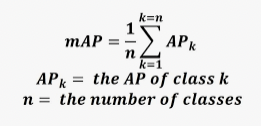

In [30]:
# 'macro' option is to calculate metrics for each label, and find their unweighted mean. 
# This does not take label imbalance into account.
from sklearn.metrics import precision_score
precision_score(y_test, np.argmax(y_pred_1, axis=-1), average='macro')

0.5293073528348771

In [31]:
test_defog_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog/02ab235146.csv'
test_defog = pd.read_csv(test_defog_path)
name = os.path.basename(test_defog_path)
id_value = name.split('.')[0]
test_defog['Id_value'] = id_value
test_defog['Id'] = test_defog['Id_value'].astype(str) + '_' + test_defog['Time'].astype(str)
test_defog = test_defog[['Id','AccV','AccML','AccAP']]
test_defog.set_index('Id',inplace=True)

In [32]:
# predict event probability
test_defog_pred=clf.predict(test_defog)
test_defog['event'] = np.argmax(test_defog_pred, axis=-1)

In [33]:
# expand event column it to three columns
test_defog['StartHesitation'] = np.where(test_defog['event']==1, 1, 0)
test_defog['Turn'] = np.where(test_defog['event']==2, 1, 0)
test_defog['Walking'] = np.where(test_defog['event']==3, 1, 0)

In [34]:
test_defog.shape

(281688, 7)

In [35]:
test_defog.head(10)

,AccV,AccML,AccAP,event,StartHesitation,Turn,Walking
Id,,,,,,,
02ab235146_0,-0.914652,-0.300851,0.298156,0,0,0,0
02ab235146_1,-0.914367,-0.301572,0.298325,0,0,0,0
02ab235146_2,-0.779540,-0.343197,0.275690,0,0,0,0
02ab235146_3,-0.993162,-0.270281,0.315775,0,0,0,0
02ab235146_4,-0.948767,-0.307849,0.297191,0,0,0,0
02ab235146_5,-0.908209,-0.298476,0.285712,0,0,0,0
02ab235146_6,-0.919048,-0.300339,0.290179,0,0,0,0
02ab235146_7,-0.917466,-0.300537,0.296862,0,0,0,0
02ab235146_8,-0.916999,-0.298138,0.300423,0,0,0,0


In [36]:
print(test_defog['event'].value_counts(),'\n')
print(test_defog['StartHesitation'].value_counts(),'\n')
print(test_defog['Turn'].value_counts(),'\n')
print(test_defog['Walking'].value_counts(),'\n')


0    281201
2       453
3        32
1         2
Name: event, dtype: int64 

0    281686
1         2
Name: StartHesitation, dtype: int64 

0    281235
1       453
Name: Turn, dtype: int64 

0    281656
1        32
Name: Walking, dtype: int64 



## tdcs model training

In [37]:
tdcsfog_m

,Id,Subject,Visit,Test,Medication,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,003f117e14,4dc2f8,3,2,on,0,-9.531250,0.566406,-1.413086,0,0,0
1,003f117e14,4dc2f8,3,2,on,1,-9.539062,0.563965,-1.440430,0,0,0
2,003f117e14,4dc2f8,3,2,on,2,-9.531250,0.561523,-1.429688,0,0,0
3,003f117e14,4dc2f8,3,2,on,3,-9.531250,0.564453,-1.415039,0,0,0
4,003f117e14,4dc2f8,3,2,on,4,-9.539062,0.562012,-1.429688,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7062667,ffda8fadfd,7fcee9,20,1,off,4220,-9.406250,0.088989,-3.220703,0,0,0
7062668,ffda8fadfd,7fcee9,20,1,off,4221,-9.406250,0.090515,-3.216797,0,0,0
7062669,ffda8fadfd,7fcee9,20,1,off,4222,-9.406250,0.084351,-3.224609,0,0,0
7062670,ffda8fadfd,7fcee9,20,1,off,4223,-9.406250,0.084229,-3.236328,0,0,0


In [38]:
conditions = [
    (tdcsfog_m['StartHesitation'] == 1),
    (tdcsfog_m['Turn'] == 1),
    (tdcsfog_m['Walking'] == 1)]
choices = ['StartHesitation', 'Turn', 'Walking']
tdcsfog_m['event'] = np.select(conditions, choices, default='Normal')

In [39]:
tdcsfog_m['event'].value_counts().to_frame().style.background_gradient()

,event
Normal,4871262
Turn,1678782
StartHesitation,304790
Walking,207838


In [40]:
train_df = tdcsfog_m[['AccV','AccML','AccAP','event']]

In [41]:
train_df['target'] = le.fit_transform(train_df['event'])

In [42]:
X = train_df.drop(['event','target'], axis=1)
y = train_df['target']

In [43]:
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)

#Converting the dataset in proper LGB format
d_train=lgb.Dataset(X_train, label=y_train)
#setting up the parameters
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=7
params['num_class']=4 #no.of unique values in the target class not inclusive of the end value
params['verbose']=-1
#training the model
clf_2=lgb.train(params,d_train,1000)  #training the model on 1,000 epocs
#prediction on the test dataset
y_pred_2=clf_2.predict(X_test)

In [44]:
y_pred_2[:1]

array([[0.98594116, 0.00161579, 0.00804576, 0.00439729]])

In [45]:
precision_score(y_test, np.argmax(y_pred_2, axis=-1), average='macro')

0.5158066206956778

In [46]:
test_tdcsfog_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/003f117e14.csv'
test_tdcsfog = pd.read_csv(test_tdcsfog_path)
name = os.path.basename(test_tdcsfog_path)
id_value = name.split('.')[0]
test_tdcsfog['Id_value'] = id_value
test_tdcsfog['Id'] = test_tdcsfog['Id_value'].astype(str) + '_' + test_tdcsfog['Time'].astype(str)
test_tdcsfog = test_tdcsfog[['Id','AccV','AccML','AccAP']]
test_tdcsfog.set_index('Id',inplace=True)

In [47]:
test_tdcsfog_pred=clf_2.predict(test_tdcsfog)
test_tdcsfog['event'] = np.argmax(test_tdcsfog_pred, axis=-1)

In [48]:
test_tdcsfog['StartHesitation'] = np.where(test_tdcsfog['event']==1, 1, 0)
test_tdcsfog['Turn'] = np.where(test_tdcsfog['event']==2, 1, 0)
test_tdcsfog['Walking'] = np.where(test_tdcsfog['event']==3, 1, 0)
test_tdcsfog.reset_index('Id', inplace=True)

In [49]:
test_tdcsfog.shape

(4682, 8)

In [50]:
test_tdcsfog.head(10)

,Id,AccV,AccML,AccAP,event,StartHesitation,Turn,Walking
0,003f117e14_0,-9.533939,0.566322,-1.413525,0,0,0,0
1,003f117e14_1,-9.536140,0.564137,-1.440621,0,0,0,0
2,003f117e14_2,-9.529345,0.561765,-1.429332,0,0,0,0
3,003f117e14_3,-9.531239,0.564227,-1.415490,0,0,0,0
4,003f117e14_4,-9.540825,0.561854,-1.429471,0,0,0,0
5,003f117e14_5,-9.536585,0.552573,-1.413949,0,0,0,0
6,003f117e14_6,-9.529543,0.548058,-1.413802,0,0,0,0
7,003f117e14_7,-9.524494,0.552772,-1.415629,0,0,0,0
8,003f117e14_8,-9.535767,0.552960,-1.420138,0,0,0,0
9,003f117e14_9,-9.529338,0.548155,-1.415914,0,0,0,0


In [51]:
print(test_tdcsfog['event'].value_counts(),'\n')
print(test_tdcsfog['StartHesitation'].value_counts(),'\n')
print(test_tdcsfog['Turn'].value_counts(),'\n')
print(test_tdcsfog['Walking'].value_counts(),'\n')

0    4407
2     275
Name: event, dtype: int64 

0    4682
Name: StartHesitation, dtype: int64 

0    4407
1     275
Name: Turn, dtype: int64 

0    4682
Name: Walking, dtype: int64 



In [52]:
submit = pd.concat([test_tdcsfog,test_defog])
submit = submit[['Id', 'StartHesitation', 'Turn','Walking']]

In [53]:
test_tdcsfog.shape

(4682, 8)

In [54]:
test_defog.shape

(281688, 7)

In [55]:
submit.shape

(286370, 4)

In [56]:
submit.head(10)

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0,0,0
1,003f117e14_1,0,0,0
2,003f117e14_2,0,0,0
3,003f117e14_3,0,0,0
4,003f117e14_4,0,0,0
5,003f117e14_5,0,0,0
6,003f117e14_6,0,0,0
7,003f117e14_7,0,0,0
8,003f117e14_8,0,0,0
9,003f117e14_9,0,0,0


In [57]:
non_zero_rows = submit[submit.iloc[:, 1:].any(axis=1)]
print(non_zero_rows.head(50))

                   Id  StartHesitation  Turn  Walking
708    003f117e14_708                0     1        0
721    003f117e14_721                0     1        0
722    003f117e14_722                0     1        0
723    003f117e14_723                0     1        0
724    003f117e14_724                0     1        0
792    003f117e14_792                0     1        0
793    003f117e14_793                0     1        0
794    003f117e14_794                0     1        0
795    003f117e14_795                0     1        0
796    003f117e14_796                0     1        0
797    003f117e14_797                0     1        0
798    003f117e14_798                0     1        0
799    003f117e14_799                0     1        0
800    003f117e14_800                0     1        0
801    003f117e14_801                0     1        0
802    003f117e14_802                0     1        0
803    003f117e14_803                0     1        0
804    003f117e14_804       

In [58]:
sample = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/sample_submission.csv')

In [59]:
sample.head(10)

,Id,StartHesitation,Turn,Walking
0,003f117e14_0,0,0,0
1,003f117e14_1,0,0,0
2,003f117e14_2,0,0,0
3,003f117e14_3,0,0,0
4,003f117e14_4,0,0,0
5,003f117e14_5,0,0,0
6,003f117e14_6,0,0,0
7,003f117e14_7,0,0,0
8,003f117e14_8,0,0,0
9,003f117e14_9,0,0,0


In [60]:
submit.to_csv('/kaggle/working/my_submission.csv', index=False)